# 8.基础 DQN 算法
- 在 2013 年的 NIPS 深度学习研讨会上，DeepMind 公司的研究团队发表了 DQN 论文，首次展示了这一直接通过卷积神经网络接受像素输入来玩转各种雅达利（Atari）游戏的强化学习算法，由此拉开了 **深度强化学习** 的序幕...

导入相关库

In [299]:
# 基本库
import random
import numpy as np
import collections
import matplotlib.pyplot as plt
# 神经网络
import torch
import torch.nn.functional as F
# Gymnasium 是一个用于开发和测试强化学习算法的工具库，为 OpenAI Gym 的更新版本（2021迁移开发）
import gymnasium as gym
# 自定义库（经之前的多次学习发现许多功能代码片段被复用,于是将这些功能包装到一个库中,便于调用）
import rl_utils

## 8.1 引出
第6节学习的Q-learning算法需要依赖一张Q表，将所有状态的Q值进行储存(如下图) :
![Q表示意图](Illustrations/Q表示意图.png)
即使状态向量仅有5个维度，将每一个维度的数值映射到 0∼5 六个整数上，状态依然达 $6^{5}=7776$ 种，Q表的大小则为 $7776\times5=38880$ 
而实际研究中多为 **连续状态空间** ，肯定不止6个整数，状态空间将会指数级增大，造成维度灾难，对计算硬件的要求很高，
同时将状态连续值映射到离散的区间，来降低环境的复杂程度，也会导致智能体无法精确地捕捉环境的动态变化细节，使算法性能降低，
对此，可以用 **函数拟合（function approximation）** 的方法来估计Q值，直接使用连续状态值，对此引出**DQN算法**

## 8.2 原理
**深度 Q 网络算法（Deep Q-Networks（DQN））** ，结合了 **深度神经网络(具有强大的表达能力)** 和 Q-learning，引入了深度神经网络来逼近Q值，能够处理高维连续的状态空间，无需对本就连续的状态向量进行离散映射（为解决 **连续状态下离散动作** 的问题）
假设神经网络用来拟合函数的参数是 $\omega$，即每一个状态下s所有可能动作a的值都能表示为 **$Q_{\omega}(s,a)$** ，而用于拟合函数 **$Q_{\omega}(s,a)$** 的神经网络称为 **Q网络**


### 神经网络的损失函数
**Q网络** 的**损失函数**则构造为均方误差的形式：
$$\omega^*=\arg\min_\omega\frac{1}{2N}\sum_{i=1}^N\left[Q_\omega\left(s_i,a_i\right)-\left(r_i+\gamma\max_{a^{\prime}}Q_\omega\left(s_i^{\prime},a^{\prime}\right)\right)\right]^2$$
- 除以2N是为了简化求导后的参数梯度

蕴意价值函数增量更新的幅度越小则损失越小，以此损失函数为优化目标愈使 **Q网络** 所拟合的函数所选择的动作价值越大

### 经验回放 + 目标网络
DQN 是Q-learning算法的一种扩展，也是一种离线策略算法，可以将收集到的数据存储起来在后续的训练中使用
DQN 引入了两个非常重要的模块——**经验回放和目标网络**，利用收集到的数据，它们能够帮助 DQN 取得稳定、出色的性能

#### 经验回放
Q-learning算法，每一个数据只会用来更新一次Q值
而一般的**有监督学习**，训练数据独立同分布时，在训练神经网络的时候，训练集当中的每个数据会被使用多次
所以 DQN 算法采用了 **经验回放（experience replay）** 方法：维护一个**回放缓冲区**，将每次从环境中采样得到的四元组数据（状态、动作、奖励、下一状态）存储到回放缓冲区中，训练 Q 网络的时候再从回放缓冲区中随机采样若干数据来进行训练。这么做解决了两个问题：
1. 提高样本效率：每一个样本可以被使用多次，十分适合深度神经网络的梯度学习.
2. 使样本满足独立假设（在 **马尔可夫决策过程（MDP）** 中交互采样得到的数据本身是不满足独立假设的，因为这一时刻的状态和上一时刻的状态有关）：非独立同分布的数据对训练神经网络有很大的影响，会使神经网络拟合到最近训练的数据上。采用经验回放可以**打破样本之间的相关性**，让其满足独立假设.

In [300]:
# 也被打包进 rl_utils
class ReplayBuffer:
    """ 经验回放池 """
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)  # 队列,先进先出

    def add(self, state, action, reward, next_state, done):  # 将数据加入buffer
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):  # 从buffer中采样数据,数量为batch_size
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done

    def size(self):  # 目前buffer中数据的数量
        return len(self.buffer)

#### 目标网络
**目标网络（target network）** 的引入是为了增强神经网络对于全局的把控，增强神经网络训练的稳定性。为实现这一目的需要两套神经网络：**训练网络与目标网络**.
**训练网络$Q_{\omega}(s,a)$** 为实时更新参数，而 **目标网络$Q_{\omega^{-}}(s,a)$** 则会滞后，每隔一定步数才会与训练网络同步参数.
其中需要明确的是，对于**损失函数**：$$\frac{1}{2}[Q_{\omega}\left(s,a\right)-\left(r+\gamma\max_{a^{\prime}}Q_{\omega^{-}}\left(s^{\prime},a^{\prime}\right)\right)]^{2}$$
-  Q值的计算是依据不同两套Q神经网络的

以此,促成训练稳定的效果.



## 8.3 CartPole环境
为实现该算法,引入模拟环境: **车杆环境(连续状态,离散动作)**
![CartPole环境示意图](Illustrations/cartpole环境.gif)

#### 规则
- 智能体的任务是通过左右移动保持车上的杆竖直，若杆的倾斜度数过大，或者车子离初始位置左右的偏离程度过大，或者坚持时间到达 200 帧，则游戏结束
在游戏中每坚持一帧，智能体能获得分数为 1 的奖励，坚持时间越长，则最后的分数越高，坚持 500 帧（CartPolev1）即可获得最高的分数
#### 详情
- 智能体的状态是一个4维向量(连续)：
![CartPole环境的状态空间](Illustrations/CartPole环境的状态空间.png)
- 动作空间大小为2(离散)：
![CartPole环境的动作空间](Illustrations/CartPole环境的动作空间.png)
- 工作在CartPole环境中的Q网络：
![在CartPole环境中的Q网络](Illustrations/在CartPole环境中的Q网络.png)
神经网络的输出在动作无限的情况下可以是一个标量
若有限(如以上只有两种动作)，可以为每一个动作输出一个Q值，选max

CartPole环境 状态空间相对简单，只有 4 个变量，因此之后的**网络结构**的代码设计也相对简单：采用一层 128 个神经元的全连接并以 ReLU 作为激活函数

In [301]:
class Qnet(torch.nn.Module):
    """只有一层隐藏层的Q网络 """
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)  # 输入到隐藏层
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)  # 隐藏层到输出层

    def forward(self, x):
        x = F.relu(self.fc1(x))  # 隐藏层使用ReLU激活函数
        return self.fc2(x)  # 输出层直接输出Q值

## 8.4 DQN算法代码实现

In [302]:
class DQN:
    """ DQN算法 """
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma, epsilon, target_update, device):
        self.action_dim = action_dim 
        #  Q 网络
        self.q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device) 
        # 目标网络
        self.target_q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device)
        # 使用Adam优化器
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=learning_rate)
        self.gamma = gamma  # 折扣因子（未来）
        self.epsilon = epsilon  # epsilon-贪婪策略
        self.target_update = target_update  # 目标网络更新频率
        self.count = 0  # 计数器,记录更新次数
        self.device = device

    def take_action(self, state):  # epsilon-贪婪策略采取动作
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            # 将列表先转换为一个单独的 numpy.ndarray与 PyTorch 张量兼容，然后再转换为 PyTorch 张量，提高效率
            state = torch.tensor(np.array([state]), dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action

    def update(self, transition_dict):
        # .view(-1, 1)转换为一个2D张量，以便与其他维度匹配并符合模型的输入要求
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)#转换为一个2D张量，以便与其他维度匹配并符合模型的输入要求
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)  # Q值
        max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)  # 下个状态的最大Q值
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)  # TD误差目标
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))  # 均方误差损失函数
        self.optimizer.zero_grad()  # PyTorch中默认梯度会累积, 非批量累积梯度任务，这里需要显式将梯度置为0
        dqn_loss.backward()  # 反向传播更新参数
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())  # 更新目标网络
        self.count += 1

超参数设置:

In [303]:
# Env设置(包括可重复性随机种子, 确保每次重新运行本节内容结果一致)
random.seed(0)       # 设置 Python 的随机种子
np.random.seed(0)    # 设置 NumPy 的随机种子
torch.manual_seed(0) # 设置 PyTorch CPU 随机种子
torch.cuda.manual_seed_all(0) # 设置 PyTorch GPU 随机种子, 由于GPU并行性, 只能极大减小偏差

env = gym.make('CartPole-v1')  # CartPole-v1 最大回合步数修改到了500步(v0为200)
# env = env.unwrapped # 获取原始环境（绕过 TimeLimit 包装器）解除最大步数500限制
env.reset(seed=0)   # 环境通常依赖于其他随机数生成器来初始化状态、进行探索(推荐位于以上随机之后)
print("Environment spec:", env.spec)

Environment spec: EnvSpec(id='CartPole-v1', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, disable_env_checker=False, kwargs={}, namespace=None, name='CartPole', version=1, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv')


reward_threshold=475.0, 如果智能体能够在每个回合中获得至少 475.0 分的奖励，那么就认为任务成功完成

In [304]:
# Gymnasium返回值不一样
re = env.step(0)
print(re) 

(array([ 0.01323574, -0.21745604, -0.04686959,  0.22950698], dtype=float32), 1.0, False, False, {})


In [305]:
# Agent
state_dim = env.observation_space.shape[0]  # 4
hidden_dim = 64
action_dim = env.action_space.n             # 2
lr = 0.0008
gamma = 0.99
epsilon = 0.01
target_update = 20
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon, target_update, device)

num_episodes = 1000
buffer_size = 25000  # 经验回放池的最大容量
replay_buffer = ReplayBuffer(buffer_size)  # 经验回收池
minimal_size = 1500   # 训练开始前回放池中最小的经验数量
batch_size = 128

In [306]:
return_list = rl_utils.train_off_policy_agent(env, agent, num_episodes, replay_buffer, minimal_size, batch_size)

Iteration 9: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, episode=1000, return=382.400]


In [307]:
print(return_list)

[9.0, 9.0, 9.0, 10.0, 9.0, 8.0, 9.0, 9.0, 8.0, 9.0, 10.0, 11.0, 10.0, 10.0, 10.0, 10.0, 9.0, 9.0, 8.0, 9.0, 9.0, 8.0, 8.0, 8.0, 9.0, 9.0, 9.0, 9.0, 9.0, 8.0, 9.0, 9.0, 10.0, 8.0, 9.0, 10.0, 11.0, 10.0, 9.0, 9.0, 10.0, 10.0, 8.0, 8.0, 10.0, 9.0, 10.0, 8.0, 8.0, 9.0, 8.0, 10.0, 10.0, 8.0, 11.0, 10.0, 9.0, 12.0, 9.0, 9.0, 9.0, 10.0, 9.0, 9.0, 9.0, 9.0, 9.0, 8.0, 8.0, 8.0, 10.0, 10.0, 10.0, 9.0, 10.0, 9.0, 10.0, 9.0, 10.0, 9.0, 11.0, 8.0, 10.0, 10.0, 9.0, 10.0, 8.0, 10.0, 10.0, 10.0, 9.0, 10.0, 9.0, 9.0, 8.0, 10.0, 8.0, 9.0, 10.0, 11.0, 10.0, 8.0, 8.0, 9.0, 9.0, 9.0, 10.0, 9.0, 10.0, 8.0, 9.0, 9.0, 9.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 9.0, 9.0, 10.0, 9.0, 9.0, 9.0, 10.0, 9.0, 10.0, 10.0, 10.0, 9.0, 8.0, 11.0, 10.0, 9.0, 10.0, 10.0, 9.0, 9.0, 10.0, 9.0, 10.0, 10.0, 10.0, 12.0, 9.0, 8.0, 9.0, 9.0, 9.0, 10.0, 10.0, 9.0, 10.0, 10.0, 9.0, 10.0, 10.0, 10.0, 9.0, 9.0, 9.0, 8.0, 10.0, 9.0, 10.0, 8.0, 11.0, 9.0, 9.0, 9.0, 10.0, 9.0, 8.0, 9.0, 8.0, 9.0, 8.0, 9.0, 10.0, 10.0, 9.0, 8.0, 10.0, 10.0

性能快速提升后，持续出现一定程度的震荡，主要是因为神经网络过拟合局部经验数据

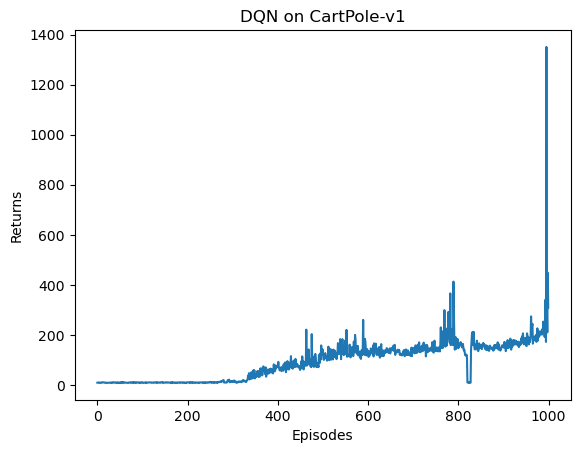

In [308]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format('CartPole-v1'))
plt.show()

去噪：滑动平均方法，使曲线更平滑：

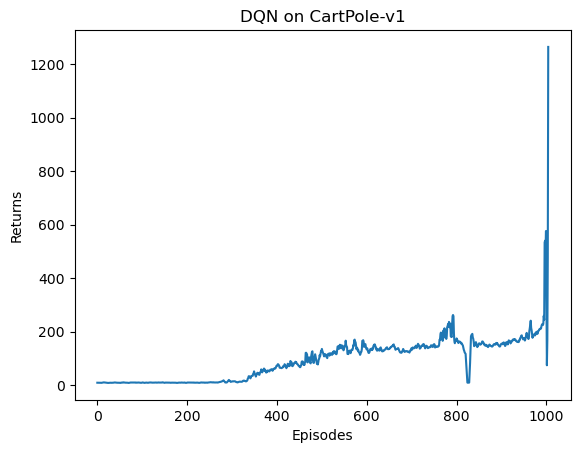

In [309]:
mv_return = rl_utils.moving_average(return_list, 4)
episodes_list2 = list(range(len(mv_return)))
plt.plot(episodes_list2, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format('CartPole-v1'))
plt.show()